# Comparison with SIB on SI model
SIB: https://www.nature.com/articles/srep27538, https://github.com/sibyl-team/sib

In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MatrixProductBP`


In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [3]:
using PyCall, SparseArrays

ENV["PYTHON"] = "/home/crotti/miniconda3/bin/python"

@pyimport sib

# convert ϕ's into observations for sib
function sib_SI_tests(ϕ::Vector{Vector{Vector{F}}}) where F
    tests = []
    for i in eachindex(ϕ)
        for t in eachindex(ϕ[i])
            ϕᵢᵗ = ϕ[i][t]
            # uniform <=> no observation
            if all(isequal(ϕᵢᵗ[1]), ϕᵢᵗ)
                nothing
            else
                push!(tests, (i-1, sib.Test(ϕᵢᵗ..., 0), t+1))
            end
        end
    end
    tests
end


function sib_SI(T::Integer, g::IndexedGraph, ϕ, p⁰, λ;
        maxiter = 400, tol = 1e-14)
    γ = p⁰[1][INFECTED]
    @assert all(isequal(γ), pᵢ⁰[INFECTED] for pᵢ⁰ in p⁰)

    contacts = [(src(e)-1, dst(e)-1, t, λ) for t in 1:T for e in edges(g)]
    append!(contacts, [(dst(e)-1, src(e)-1, t, λ) for t in 1:T for e in edges(g)])
    sort!(contacts, by=x->x[3])
    tests = sib_SI_tests(ϕ)
    params = sib.Params(prob_r=sib.Exponential(1e-100), pseed=γ, 
        pautoinf=0.0)
    f = sib.FactorGraph(contacts=contacts, tests=tests, params=params)
    sib.iterate(f, maxit=maxiter, tol=tol)
    sib.iterate(f, maxit=maxiter, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxiter, damping=0.9, tol=tol)

    marginals_sib = map(f.nodes) do i
        map(1:T) do t 
            m = sib.marginal_t(i, t)
            @assert m[3] ≈ 0
            [m[1], m[2]]
        end
    end

    F_bethe = - f.loglikelihood()
    F_detail = [- n.fa for n in f.nodes]

    return marginals_sib, F_bethe, F_detail
end

sib_SI (generic function with 1 method)

In [85]:
q = q_sis
T = 10
N = 30
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.15
κ = 0.0   # SI
γ = 0.2
sis = SIS(g, λ, κ, T; γ);

In [94]:
bp = mpbp(sis)
nobs = N
draw_node_observations!(bp, nobs, last_time=true)
cb = CB_BP(bp);

In [106]:
svd_trunc = TruncBond(4)
iters, cb = iterate!(bp, maxiter=100; svd_trunc, cb, tol=1e-10);

Running MPBP: iter 49 	 Time: 0:01:45
  Δ:  6.52304108890075e-11

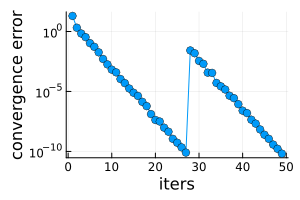

In [107]:
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", m=:o, yaxis=:log10, 
    size=(300,200), label="")

In [108]:
fe_bp = cb.f[end]
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

Run sib

In [109]:
b_sib, fe_sib = sib_SI(T, g, bp.ϕ, bp.p⁰, λ)
p_sib = [[bbb[2] for bbb in bb] for bb in b_sib];

sib.iterate(damp=0.0): 40/400 4.940e-15/1e-14      
sib.iterate(damp=0.5): 0/400 1.929e-15/1e-14      
sib.iterate(damp=0.9): 0/400 9.159e-16/1e-14      


SI on random regular graph N=30, k=3. P(S→I)=0.15.
30 random observations.
Max matrix size: 4x4


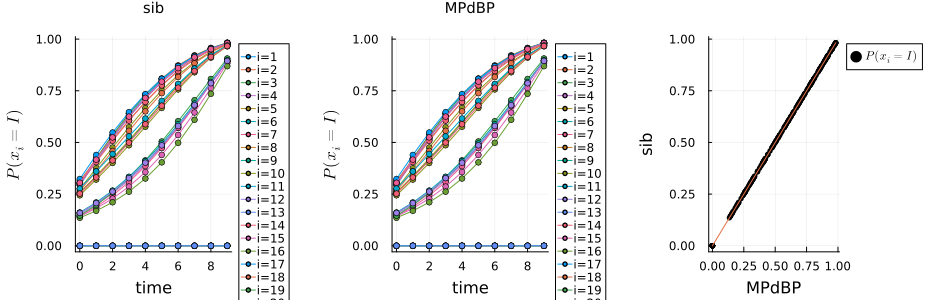

In [110]:
pl_sib = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:2:T-1, title="sib")
for i in 1:N
    plot!(pl_sib, 0:T-1, p_sib[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:2:T-1, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T-1, p_bp[i][1:T], label="i=$i", m=:o, ms=3, lw=1)
end
println("SI on random regular graph N=$N, k=$k. P(S→I)=$λ.")
println("$nobs random observations.")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
pl_sc = scatter(reduce(vcat, [p[1:end-1] for p in p_bp]), reduce(vcat, p_sib), xlabel="MPdBP", 
    ylabel="sib", label="\$P(x_i=I)\$",  ms=3, c=:black, legend=:outertopright)
plot!(pl_sc, identity, label="", size=(300,300))
plot(pl_sib, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

Compare estimates for the free energy

In [111]:
fe_bp, fe_sib

(11.524762049864336, 11.524762049848988)

In [112]:
(fe_bp - fe_sib) / fe_sib

1.3317171344651988e-12

In [113]:
abs.(p_bp[1][1:T] - p_sib[1])

10-element Vector{Float64}:
 2.942091015256665e-13
 5.387912338505885e-13
 7.084333120133124e-13
 7.809308755213351e-13
 7.579492589115944e-13
 6.604716773495056e-13
 5.170308625679354e-13
 3.5849101465146305e-13
 2.107203300738547e-13
 8.881784197001252e-14